In [ ]:
## This is a modified SPANISH version of a GPT-2 Notebook from: https://colab.research.google.com/github/mc51/blog_posts/blob/master/doctors_nlp4.ipynb

In [ ]:
import os

# Do this only Google Colab
if os.environ.get("COLAB_GPU", False):
    !pip install -U datasets transformers

import warnings
import re
import random
import datasets
import transformers
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from transformers import AutoTokenizer,TFGPT2LMHeadModel
from datasets import Dataset, load_dataset

In [ ]:
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  ['10.87.242.242:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.87.242.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.87.242.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
# read data
reviews = pd.read_csv("tweets.csv")
reviews.head(3)

,id,text,Sentimiento
0,1134612598014582785,2da generación de cambios !! Es con @CosseCar...,<|pos|>
1,1134628742612082688,@gbianchi404 buenísimo!! ya le pasó la yeta!!!,<|pos|>
2,1134629055582658560,@gbianchi404 Sra se despertó de su letargo sig...,<|pos|>


In [ ]:
reviews["Sentimiento"].value_counts()

<|neu|>    50122
<|neg|>    37821
<|pos|>    16726
Name: Sentimiento, dtype: int64

In [ ]:
%%time
def clean_text(text):
    """
    - remove any html tags (< /br> often found)
    - Keep only ASCII + Latin chars, digits and whitespaces
    - pad punctuation chars with whitespace
    - convert all whitespaces (tabs etc.) to single wspace
    """
    RE_PUNCTUATION = re.compile("([!?.,;-])")
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!?0-9 ]", re.IGNORECASE)
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_PUNCTUATION, r" \1 ", text)
    text = re.sub(RE_WSPACE, " ", text)
    text = re.sub(r'([!¡]\s?){3,}', r' $EXCLAMATION$ ', text)
    text = re.sub(r'([¿?]\s?){3,}', r' $QUESTION$ ', text)
    text = re.sub(r'(\.\s?){3,}', r' $ELLIPSIS$ ', text)
    text = re.sub(r'\b(?:a*(?:(h+|j+)a+|s+)+(h+|j+)?|(?:l+o+)+l+)\b', r' $LOL$ ', text, flags=re.I)
    return text


# Clean Comments. Only keep long enough
reviews["text_clean"] = reviews.loc[reviews["text"].str.len() > 10, "text"]
reviews["text_clean"] = reviews["text"].map(
    lambda x: clean_text(x) if isinstance(x, str) else x
)

CPU times: user 6.98 s, sys: 59.7 ms, total: 7.04 s
Wall time: 7.08 s


In [ ]:
# Drop Missing and save to file
reviews = reviews.dropna(axis="index", subset=["text_clean"]).reset_index(drop=True)
# add rating indicator as first word of comment
reviews["text_clean"] = reviews["Sentimiento"] + " " + reviews["text_clean"]
data = reviews[["text_clean"]]
data.columns = ["text"]
data.to_csv('clean_tweets.csv',index=False)
data.head(2)

,text
0,<|pos|> 2da generación de cambios ! ! Es con C...
1,<|pos|> gbianchi404 buenísimo ! ! ya le pasó ...


In [ ]:
# Read data from file and load as dataset
data = pd.read_csv('clean_tweets.csv')
data = Dataset.from_pandas(data)
data

Dataset({
    features: ['text'],
    num_rows: 104669
})

In [ ]:
MAX_TOKENS = 128
POS_TOKEN = "<|pos|>"
NEG_TOKEN = "<|neg|>"
NEU_TOKEN = "<|neu|>"
BOS_TOKENS = [NEG_TOKEN, POS_TOKEN, NEU_TOKEN]
EOS_TOKEN = "<|endoftext|>"
PAD_TOKEN = "<|pad|>"

# this will download and initialize the pre trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("DeepESP/gpt2-spanish",
    eos_token=EOS_TOKEN,
    pad_token=PAD_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)
tokenizer.add_tokens(BOS_TOKENS, special_tokens=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


3

In [ ]:
%%time

output = {}
# texts to numeric vectors of MAX_TOKENS
def tokenize_function(examples, tokenizer=tokenizer):
    # Add start and end token to each comment
    examples = [ex + EOS_TOKEN for ex in examples["text"]]
    # tokenizer created input_ids and attention_mask as output
    output = tokenizer(
        examples,
        add_special_tokens=True,  # Only adds pad not eos and bos
        max_length=MAX_TOKENS,
        truncation=True,
        pad_to_max_length=True,
    )
    # shift labels for next token prediction
    # set padding token labels to -100 which is ignored in loss computation
    output["labels"] = [x[1:] for x in output["input_ids"]]
    output["labels"] = [
        [-100 if x == tokenizer.pad_token_id else x for x in y]
        for y in output["labels"]
    ]
    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output


data = data.map(
    tokenize_function,
    batched=True,
    num_proc=strategy.num_replicas_in_sync,
    remove_columns=["text"],
    load_from_cache_file=True,
)
print(data)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Dataset({
    features: ['attention_mask', 'input_ids', 'labels'],
    num_rows: 104669
})
CPU times: user 2.3 s, sys: 914 ms, total: 3.21 s
Wall time: 40.5 s


In [ ]:
# Load Inputs and create test and train split
data.save_to_disk('tokenized_tweets')
data = datasets.load_from_disk('tokenized_tweets')
data.set_format(type="python", columns=["input_ids", "attention_mask", "labels"])
data = data.train_test_split(
    test_size=0.20, shuffle=True, seed=1, load_from_cache_file=True
)
print(data)

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 83735
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 20934
    })
})


In [ ]:
%%time
# prepare for use in tensorflow
train_tensor_inputs = tf.convert_to_tensor(data["train"]["input_ids"])
train_tensor_labels = tf.convert_to_tensor(data["train"]["labels"])
train_tensor_mask = tf.convert_to_tensor(data["train"]["attention_mask"])
train = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": train_tensor_inputs, "attention_mask": train_tensor_mask},
        train_tensor_labels,
    )
)

test_tensor_inputs = tf.convert_to_tensor(data["test"]["input_ids"])
test_tensor_labels = tf.convert_to_tensor(data["test"]["labels"])
test_tensor_mask = tf.convert_to_tensor(data["test"]["attention_mask"])
test = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": test_tensor_inputs, "attention_mask": test_tensor_mask},
        test_tensor_labels,
    )
)

CPU times: user 32.1 s, sys: 1.03 s, total: 33.1 s
Wall time: 33 s


This concludes the data preparation.

### Build and train GPT-2 Model

Next, we can start defining our model architecture:

In [ ]:
# Model params
BATCH_SIZE_PER_REPLICA = 32
EPOCHS = 3
INITAL_LEARNING_RATE = 0.001
try:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
except NameError as e:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA
BUFFER_SIZE = len(train)

# prepare data for consumption
train_ds = (
    train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
)
test_ds = test.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# Drecreasing learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    INITAL_LEARNING_RATE,
    decay_steps=300,
    decay_rate=0.008,
    staircase=True)

# initialize model, use_cache=False important! else wrong shape at loss calc
with strategy.scope():
    model = TFGPT2LMHeadModel.from_pretrained("DeepESP/gpt2-spanish",
        use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    model.resize_token_embeddings(len(tokenizer))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss=model.compute_loss)
    model.summary()

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at DeepESP/gpt2-spanish.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124442880 
 r)                                                              
                                                                 
Total params: 124,442,880
Trainable params: 124,442,880
Non-trainable params: 0
_________________________________________________________________


In [ ]:
''' # Stop training when validation acc starts dropping
# Save checkpoint of model after each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, patience=1, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "/content/callbacks/" + now + "_GPT2-Model_{epoch:02d}_{val_loss:.4f}.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    ),
] '''

' # Stop training when validation acc starts dropping\n# Save checkpoint of model after each period\nnow = datetime.now().strftime("%Y-%m-%d_%H%M")\n# Create callbacks\ncallbacks = [\n    tf.keras.callbacks.EarlyStopping(\n        monitor="val_loss", verbose=1, patience=1, restore_best_weights=True\n    ),\n    tf.keras.callbacks.ModelCheckpoint(\n        "/content/callbacks/" + now + "_GPT2-Model_{epoch:02d}_{val_loss:.4f}.h5",\n        monitor="val_loss",\n        save_best_only=True,\n        verbose=1,\n    ),\n] '

In [ ]:
%%time
# Train Model
steps_per_epoch = int(BUFFER_SIZE // BATCH_SIZE)
print(
    f"Model Params:\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
    f"Initial Learning rate: {INITAL_LEARNING_RATE}"
)
hist = model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

Model Params:
batch_size: 256
Epochs: 3
Step p. Epoch: 327
Initial Learning rate: 0.001
Epoch 1/3
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


327/327 [==============================] - 236s 493ms/step - loss: 3.9224 - val_loss: 3.5298
Epoch 2/3
327/327 [==============================] - 153s 468ms/step - loss: 3.1907 - val_loss: 3.4976
Epoch 3/3
327/327 [==============================] - 153s 469ms/step - loss: 3.1569 - val_loss: 3.4975
CPU times: user 51.2 s, sys: 3.72 s, total: 55 s
Wall time: 9min 5s


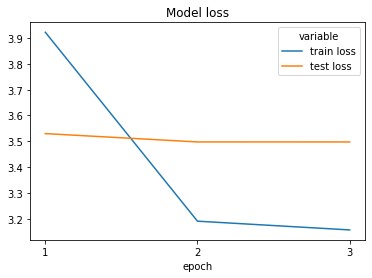

In [ ]:
 loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss",
    ylabel="",
    xticks=range(1, loss["epoch"].max() + 1),
    xticklabels=loss["epoch"].unique(),
);

In [ ]:
# Restored Trained Model weights
# model.load_weights(PATH_BASE + "/data/models/2021-03-21_1925_GPT2-Model_03_2.8273.h5")

from transformers import pipeline

review = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

In [ ]:
gen_pos = review("<|pos|>", max_length=150, num_return_sequences=6)
pd.DataFrame(gen_pos)

,generated_text
0,<|pos|> adeladubra El futuro de los Uruguayos...
1,"<|pos|> gbianchi404 Felicitaciones Graciela, ..."
2,<|pos|> EsMonicaFA Qué orgullo!!
3,<|pos|> Que orgullo que los de mi confianza no...
4,<|pos|> Vimos este gobierno para seguir avanza...
5,<|pos|> gbianchi404 Todo un éxito.


In [ ]:
gen_pos

[{'generated_text': '<|pos|>  adeladubra El futuro de los Uruguayos, de las manos del pueblo y de la gente, muy poco probable, muy mal perdedor! '},
 {'generated_text': '<|pos|>  gbianchi404 Felicitaciones Graciela, el mejor país para ti también. '},
 {'generated_text': '<|pos|>  EsMonicaFA Qué orgullo!! '},
 {'generated_text': '<|pos|> Que orgullo que los de mi confianza nos compartan y recuerden ese día de cumpleaños de la CosseCarolina  $EXCLAMATION$ Por dios  $EXCLAMATION$ '},
 {'generated_text': '<|pos|> Vimos este gobierno para seguir avanzando desde nuestro lanzamiento!! '},
 {'generated_text': '<|pos|>  gbianchi404 Todo un éxito. '}]

In [ ]:
gen_neg = review("<|neg|>", max_length=150, num_return_sequences=6)
pd.DataFrame(gen_neg)

,generated_text
0,<|neg|> CosseCarolina No te veo tan preocupad...
1,<|neg|> gbianchi404 Son unos atrevidos que no...
2,<|neg|> gbianchi404 Sos una vergüenza y te fa...
3,<|neg|> beatrizargimon Un poco más largo el a...
4,<|neg|> CosseCarolina Cómo se llama esto?
5,"<|neg|> EsMonicaFA Esta vieja loca, no merece..."


In [ ]:
gen_neg

[{'generated_text': '<|neg|>  CosseCarolina No te veo tan preocupada porque cuando vas a condenar los DDHH se van a ir porque los que se van no los quieren. '},
 {'generated_text': '<|neg|>  gbianchi404 Son unos atrevidos que nos representan, no les interesa'},
 {'generated_text': '<|neg|>  gbianchi404 Sos una vergüenza y te falto la vida '},
 {'generated_text': '<|neg|>  beatrizargimon Un poco más largo el artículo del reglamento por favor, te pido que expliques si estás mal de la cabeza, no seas hipócrita'},
 {'generated_text': '<|neg|>  CosseCarolina Cómo se llama esto? '},
 {'generated_text': '<|neg|>  EsMonicaFA Esta vieja loca, no merece nada. '}]

In [ ]:
gen_neu = review("<|neu|>", max_length=150, num_return_sequences=6)
pd.DataFrame(gen_neu)

,generated_text
0,<|neu|> $LOL$ en serio??
1,<|neu|> CosseCarolina En este video tu amigo ...
2,<|neu|> gbianchi404 Graciela no. Ya lo sabemo...
3,<|neu|> CosseCarolina Caro te parece correcto...
4,<|neu|> CosseCarolina En vez de apoyar la ref...
5,<|neu|> Muy clara lauraraffo


In [ ]:
gen_neu

[{'generated_text': '<|neu|>  $LOL$  en serio?? '},
 {'generated_text': '<|neu|>  CosseCarolina En este video tu amigo dijo que el costo era posible!! '},
 {'generated_text': '<|neu|>  gbianchi404 Graciela no. Ya lo sabemos. Creo que a Ud. le interesa la educación de muchas personas. '},
 {'generated_text': '<|neu|>  CosseCarolina Caro te parece correcto que hablás con coherencia? '},
 {'generated_text': '<|neu|>  CosseCarolina En vez de apoyar la reforma  $ELLIPSIS$ es de cuarta y sin la LUC nadie les va a escuchar. '},
 {'generated_text': '<|neu|> Muy clara lauraraffo'}]